# Problem Set 2

## Question 1

We solve the PDE
$$0=-r\,g(x,t) + g_t(x,t) + g_x(x,t)\,r\,x + \frac{1}{2}g_{xx}(x,t)\,\sigma^2\,x^2$$

by replacing the derivatives with finite differences on a grid $i, j \in [Q_0, Q_I] \times [t_0,t_J]$. Using forward differentiation in the time direction is particularily convenient, because the resulting linear system of equations is small.

### 1

In [2]:
using Parameters, BenchmarkTools
using Plots; pyplot()
using Distributions, NLsolve

@with_kw struct KFE
    T::Float64 = 2.                                                  # t ∈ [0, T]
    J::Int64 = 400                                                   # t ∈ [t_0, t_J]
    Tgrid::Vector{Float64} = collect(range(0, stop = T, length = J)) # J grid

    x0::Float64 = -5.                                                  # lower bound
    xI::Float64 = 5.                                                   # upper bound
    I::Int64 = 100                                                     # x ∈ [x_0, x_I]
    xgrid::Vector{Float64} = collect(range(x0, stop = xI, length = I)) # I grid

    σ::Float64 = 1.
    θ::Float64 = 0.
    xbar::Float64= 0.
    
    #boundary values
    μ0::Float64 = 0. 
    v0::Float64 = 0.1
    p_initial::Function = x -> pdf(Normal(μ0, v0), x)
    p_lower::Function = t -> 0.
    p_upper::Function = t -> 0.
    
end;

In [117]:
#define finite difference functions, a wrapper function, and the analytic solution
function dx_forward!(kfe::KFE, p, px)
    #forward difference
    for i in 1:kfe.I - 1
        px[i] = (p[i+1] - p[i]) / (kfe.xgrid[i+1] - kfe.xgrid[i])
    end
    
    #backward difference for the upper bound
    px[kfe.I] = (p[kfe.I] - p[kfe.I-1]) / (kfe.xgrid[kfe.I] - kfe.xgrid[kfe.I-1])
    
    return nothing
end

function dx_backward!(kfe::KFE, p, px)
    
    #forward difference for the lower bound
    px[1] = (p[2] - p[1]) / (kfe.xgrid[2] - kfe.xgrid[1])
        
    #backward difference
    for i in 2:kfe.I
        px[i] = (p[i] - p[i-1]) / (kfe.xgrid[i] - kfe.xgrid[i-1])
    end
    
    return nothing
end

function dx_central!(kfe::KFE, p, px)
    
    #forward difference for the lower bound
    px[1] = (p[2] - p[1]) / (kfe.xgrid[2] - kfe.xgrid[1])
        
    #central difference
    for i in 2:kfe.I-1
        px[i] = (p[i+1] - p[i-1]) / (kfe.xgrid[i+1] - kfe.xgrid[i-1])
    end
    
    #backward difference for the upper bound
    px[kfe.I] = (p[kfe.I] - p[kfe.I-1]) / (kfe.xgrid[kfe.I] - kfe.xgrid[kfe.I-1])
    
    return nothing
end

function dx_upwind!(kfe::KFE, p, px)
    
    #forward difference for the lower bound
    px[1] = (p[2] - p[1]) / (kfe.xgrid[2] - kfe.xgrid[1])
        
    #central difference
    for i in 2:kfe.I-1
        if kfe.θ * (kfe.xbar - kfe.xgrid[i]) >= 0 
            #forward
            px[i] = (p[i+1] - p[i]) / (kfe.xgrid[i+1] - kfe.xgrid[i])
        else
            #backward
            px[i] = (p[i] - p[i-1]) / (kfe.xgrid[i] - kfe.xgrid[i-1])
        end
    end
    
    #backward difference for the upper bound
    px[kfe.I] = (p[kfe.I] - p[kfe.I-1]) / (kfe.xgrid[kfe.I] - kfe.xgrid[kfe.I-1])
    
    return nothing
end

function dxx!(kfe::KFE, p, pxx)
#forward difference for the lower bound
   pxx[1] = (p[3] + p[1] - 2 * p[2]) / (kfe.xgrid[2] - kfe.xgrid[1])^2
   
   #central difference
   for i in 2:kfe.I-1
        pxx[i] = (p[i+1] + p[i-1] - 2 * p[i]) / (kfe.xgrid[i+1] - kfe.xgrid[i])^2
    end
    
    #backward difference for the upper bound
    pxx[kfe.I] = (p[kfe.I] + p[kfe.I-2]) / (kfe.xgrid[kfe.I] - kfe.xgrid[kfe.I-1])^2

    return nothing
    end;

"""
    function residual_wrapper(p_old, kfe::KFE, j::Int64, dx!::Function)

takes the previous density `p_old`, book-keeping variables and a function that calculates the 
first differences and builds an enclosure around the returned function that calculates the 
error of the system of equations, given a proposed current density `p_interior` which contains
the interior points only. The boundary values are taken from `kfe`.

The returned function takes `(residual, p_interior)` and sets `residual` in-place.
"""
function residual_wrapper(p_old, kfe::KFE, j::Int64, dx!::Function)
    
    @unpack T, J, Tgrid, x0, xI, I, xgrid, σ, θ, xbar, p_initial, p_lower, p_upper = kfe
       
    return (residual, p_interior) -> begin
        px = Vector{eltype(p_interior)}(undef, length(p_interior)+2)
        pxx = Vector{eltype(p_interior)}(undef, length(p_interior)+2)

        p = vcat(p_lower(j), p_interior, p_upper(j))
        dx!(kfe, p, px)
        dxx!(kfe, p, pxx)
        
        for i in 2:I-1
            residual[i-1] = (θ * (xgrid[i] - xbar) * px[i] + θ * p[i] + σ^2/2 * pxx[i]) - 
                (p[i] - p_old[i]) / (Tgrid[j] - Tgrid[j-1])
        end
    end
end;

function v(kfe, t)
    @unpack T, J, Tgrid, x0, xI, I, xgrid, σ, θ, xbar, μ0, v0, p_initial, p_lower, p_upper = kfe
    θ == 0. ? v0 : v0 * exp(-2 * θ * t) + (1 - exp(-2 * θ * t)) * σ^2 / (2 * θ)
end

function m(kfe, t)
    @unpack T, J, Tgrid, x0, xI, I, xgrid, σ, θ, xbar, μ0, v0, p_initial, p_lower, p_upper = kfe
    μ0 * exp(-θ * t) + (1 - exp(-θ * t)) * xbar
end

function p_analytic(x, t, kfe)
    1 / √(v(kfe, t)) * pdf(Normal(), (x - m(kfe, t)) / √(v(kfe, t)))
end;

In [7]:
?residual_wrapper

search: residual_wrapper



```
function residual_wrapper(p_old, kfe::KFE, j::Int64, dx!::Function)
```

takes the previous density `p_old`, book-keeping variables and a function that calculates the  first differences and builds an enclosure around the returned function that calculates the  error of the system of equations, given a proposed current density `p_interior` which contains the interior points only. The boundary values are taken from `kfe`.

The returned function takes `(residual, p_interior)` and sets `residual` in-place.


In [8]:
"""
    function solve_pde(kfe, dx!, dxx!; explicit::Bool)

solves a KFE defined by `kfe` usind the provided finite difference functions either explicitly
or implicity.
"""
function solve_pde(kfe, dx!, dxx!; explicit::Bool)

    @unpack T, J, Tgrid, x0, xI, I, xgrid, σ, θ, xbar, μ0, v0, p_initial, p_lower, p_upper = kfe

    p = zeros(I, J)
    px = zeros(I)
    pxx = zeros(I)

    #boundary values
    p[:, 1] = p_initial.(xgrid)
    p[1, :] = p_lower.(Tgrid)
    p[end, :] = p_upper.(Tgrid)

    if explicit
        for j in 2:J
            #calculate derivatives based on last period
            dx!(kfe, p[:, j-1], px)
            dxx!(kfe, p[:, j-1], pxx)

            for i in 2:I-1
                p[i, j] = (θ * (xgrid[i] - xbar) * px[i] +
                    θ * p[i,j-1] + σ^2/2 * pxx[i]) * (Tgrid[j] - Tgrid[j-1]) + p[i, j-1]
            end
        end
    else
        for j in 2:J
            p[2:I-1, j] .= nlsolve(residual_wrapper(p[:,j-1], kfe, j, dx!), 
                p[2:I-1,j-1], iterations = 25, 
                autodiff=:forward, method = :newton, ftol = 1e-9).zero
        end
    end
    
    return p
end;

### 2

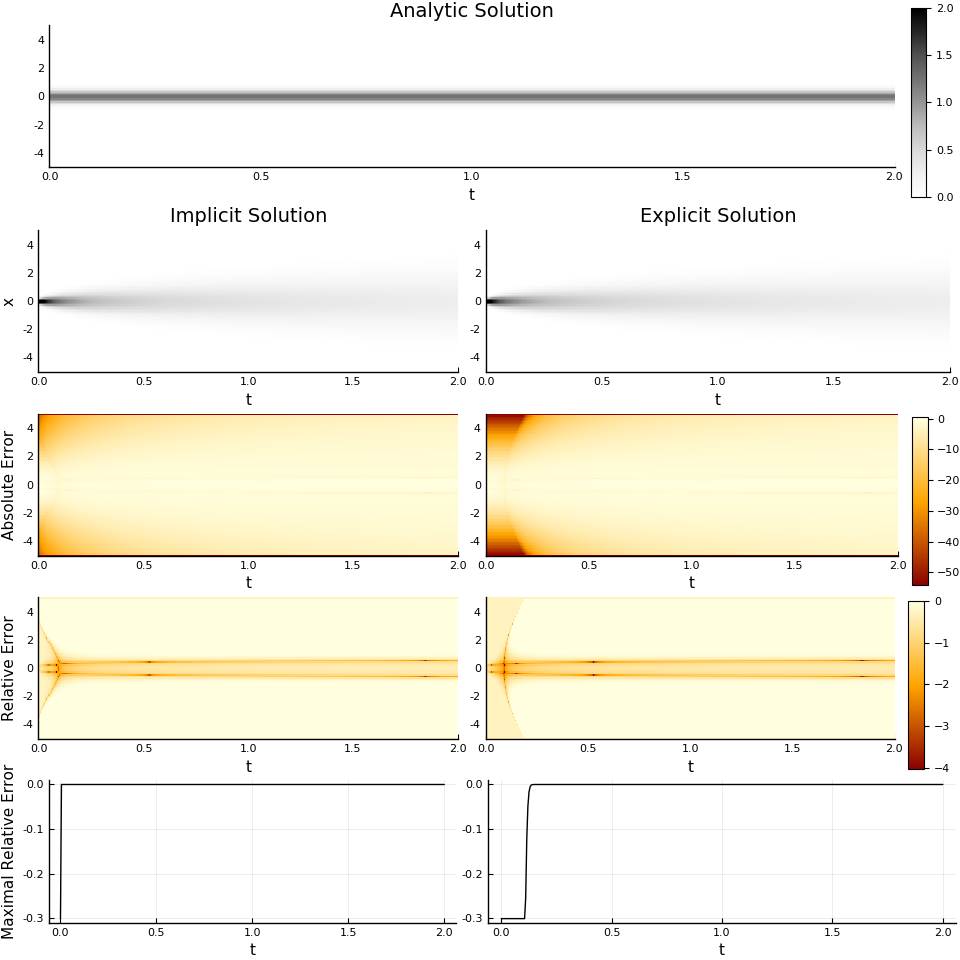

In [112]:
function create_plots(kfe = KFE())
    analytic = [p_analytic(x, t, kfe) for x in kfe.xgrid, t in kfe.Tgrid]
    implicit = solve_pde(kfe, dx_central!, dxx!, explicit = false)
    explicit = solve_pde(kfe, dx_central!, dxx!, explicit = true)

    p1 = heatmap(kfe.Tgrid, kfe.xgrid, analytic,
        clim = (0, 2), c = :Greys, title = "Analytic Solution")

    p2 = heatmap(kfe.Tgrid, kfe.xgrid, implicit, ylab = "x",
        clim = (0, 2), c = :Greys, title = "Implicit Solution", legend = :none)

    p3 = heatmap(kfe.Tgrid, kfe.xgrid, explicit, 
        clim = (0, 2), c = :Greys, title = "Explicit Solution", legend = :none)

    absolute(p) = log10(abs(p[1] - p[2]))
    relative(p) = log10(abs(p[1] - p[2]) / (2 * abs(p[1]) + abs(p[2])))

    p4 = heatmap(kfe.Tgrid, kfe.xgrid, [absolute(p) for p = zip(analytic, implicit)], 
        legend = :none, c = :heat_r, ylab = "Absolute Error")

    p5 = heatmap(kfe.Tgrid, kfe.xgrid, [absolute(p) for p = zip(analytic, explicit)], 
        c = :heat_r)

    p6 = heatmap(kfe.Tgrid, kfe.xgrid, [relative(p) for p = zip(analytic, implicit)], 
        legend = :none, c = :heat_r, ylab = "Relative Error")

    p7 = heatmap(kfe.Tgrid, kfe.xgrid, [relative(p) for p = zip(analytic, explicit)], 
        c = :heat_r)

    p8 = plot(kfe.Tgrid, maximum([relative(p) for p = zip(analytic, implicit)], dims=1)', 
        ylab = "Maximal Relative Error", legend = :none, c = :black)

    p9 = plot(kfe.Tgrid, maximum([relative(p) for p = zip(analytic, explicit)], dims=1)', 
        legend = :none, c = :black)

    plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, xlab = "t", 
        size= (960, 960), layout = @layout[a; b c; d e; f g; h j])
end

create_plots()

### 3

The solution appears to be more precise!

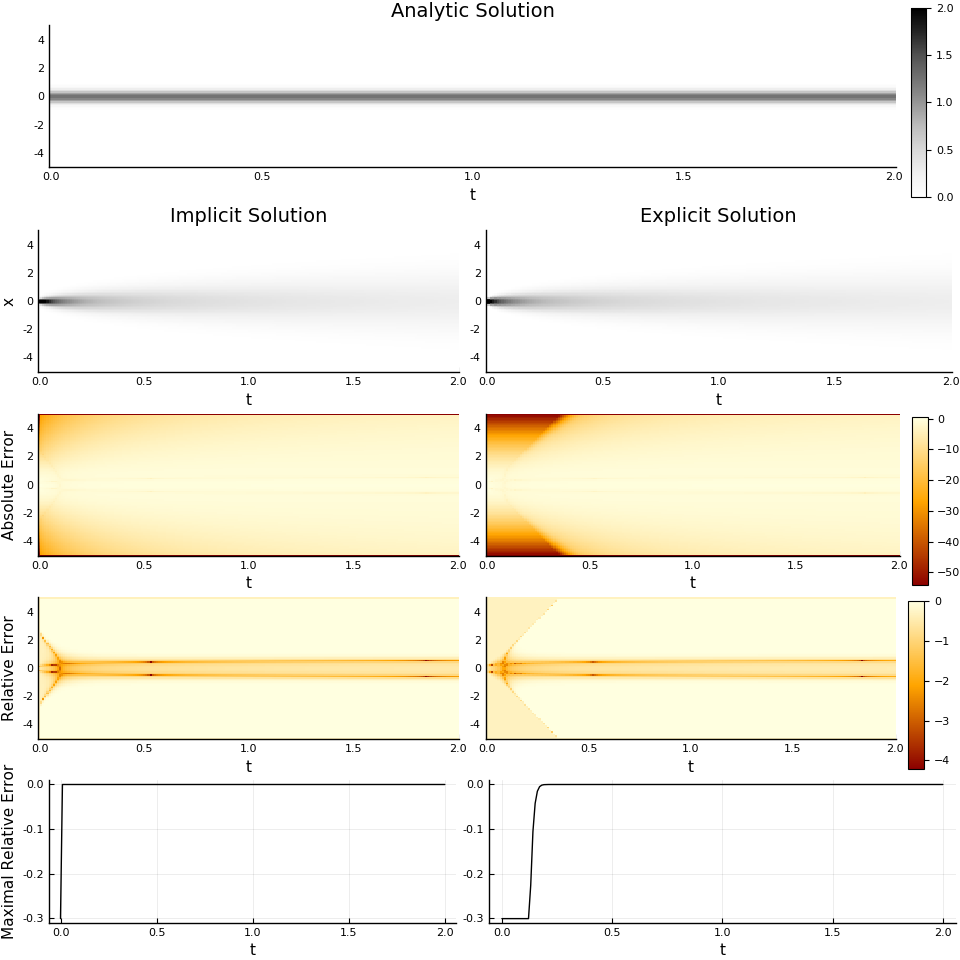

In [113]:
create_plots(KFE(J = 200))

### 4

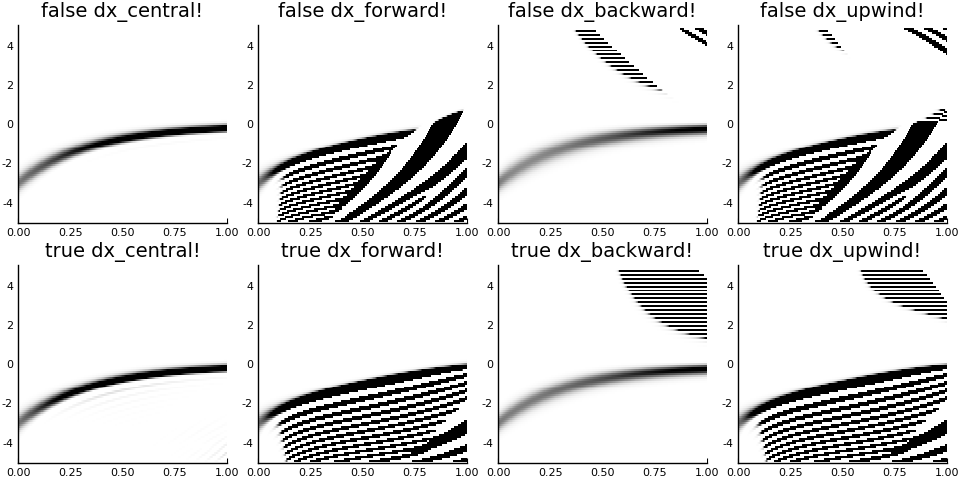

In [158]:
kfe = KFE(θ = 3., σ = 0.33, v0 = 0.33, μ0 = -3., T = 1.)

plots = [heatmap(kfe.Tgrid, kfe.xgrid, solve_pde(kfe, dx!, dxx!, explicit = explicit), clim = (0, 2), c = :Greys, title = "$(explicit) " * string(dx!), legend = :none) 
    for (dx!, explicit) in Base.Iterators.product([dx_central!, dx_forward!, dx_backward!, dx_upwind!], [false, true])]

plot(plots..., layout = @layout[a b c d; e f g h], size = (960, 480))

Central differences work best! The other solutions are not acceptable...

### 5

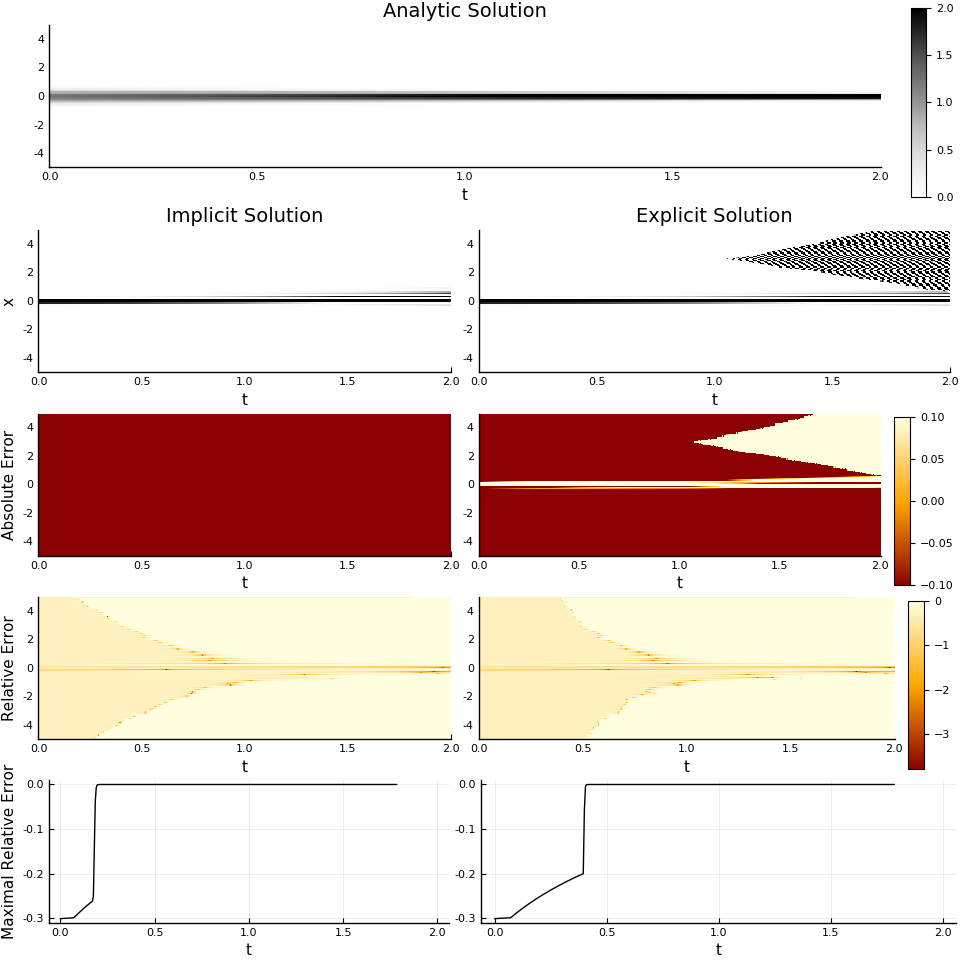

In [188]:
create_plots(KFE(θ = 0.5, σ = 0., I = 200, xgrid = sort(-5 .+ 10 .* rand(200))))